In [1]:
from datetime import datetime
from functools import reduce
from itertools import combinations
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pickle
import xgboost as xgb
import sys
import local_functions as lf
print(sys.version)

3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:48) [Clang 13.0.0 (clang-1300.0.29.30)]


In [2]:
csv_files = [
    'CSVs/R3A_Cicles_Sup.csv',
    'CSVs/R3A_Cicles_Inf.csv',
    'CSVs/R3B_Cicles_Sup.csv',
    'CSVs/R3B_Cicles_Inf.csv',
    'CSVs/R3C_Cicles_Sup.csv',
    'CSVs/R3C_Cicles_Inf.csv',
    'CSVs/R3D_Cicles_Sup.csv',
    'CSVs/R3D_Cicles_Inf.csv',
    ]
dfs_names = [
    "R3A_Sup", "R3A_Inf",
    "R3B_Sup", "R3B_Inf",
    "R3C_Sup", "R3C_Inf",
    "R3D_Sup", "R3D_Inf",
    ]

Chemical_days = dict(
    R3A_Sup = ['15-06-2022','16-06-2022','25-10-2022','27-10-2022','02-01-2023','08-03-2023','15-04-2023','17-04-2023','14-06-2023','21-08-2023','16-10-2023','08-01-2024','18-03-2024'],
    R3A_Inf = ['15-06-2022','16-06-2022','25-10-2022','27-10-2022','02-01-2023','08-03-2023','15-04-2023','17-04-2023','14-06-2023','21-08-2023','16-10-2023','08-01-2024','18-03-2024'],
    R3B_Sup = ["27-10-2022","08-11-2022","03-01-2023","19-01-2023","28-03-2023","07-04-2023","21-04-2023","04-05-2023","19-05-2023","19-06-2023","07-07-2023","02-10-2023","10-01-2024","14-02-2024","13-04-2024"],
    R3B_Inf = ["27-10-2022","08-11-2022","03-01-2023","19-01-2023","28-03-2023","07-04-2023","21-04-2023","04-05-2023","19-05-2023","19-06-2023","07-07-2023","02-10-2023","10-01-2024","14-02-2024","13-04-2024"],
    R3C_Sup = ["14-11-2022","10-04-2023","10-08-2023","09-11-2023","10-01-2024","17-02-2024"],
    R3C_Inf = ["14-11-2022","10-04-2023","10-08-2023","09-11-2023","10-01-2024","17-02-2024"],
    R3D_Sup = ["31-01-2023","02-05-2023","29-06-2023","22-08-2023","02-11-2023","12-01-2024","13-02-2024"],
    R3D_Inf = ["31-01-2023","02-05-2023","29-06-2023","22-08-2023","02-11-2023","12-01-2024","13-02-2024"],
)
Chemical_days = {
    key: [datetime.strptime(fecha, '%d-%m-%Y').date() for fecha in fechas]
    for key, fechas in Chemical_days.items()
}


In [3]:
DataFrames  = dict()
for csvfile, line  in zip(csv_files, dfs_names):
    DataFrames[line] = pd.read_csv(csvfile)
    DataFrames[line].columns = ['ID','Date','Qair', 'Qperm', 'TMP', 'O2','Temp', 'TSS', 'NH4', 'NO3','Flux', 'Permeab', 'Hz']
    DataFrames[line].sort_values(by = 'Date', inplace = True)
    DataFrames[line].dropna(inplace=True)
    DataFrames[line].drop(['ID'], axis=1, inplace = True)
    DataFrames[line]['Date'] = pd.to_datetime(DataFrames[line]['Date'])
    DataFrames[line].reset_index(drop = True, inplace = True)
DataFrames['R3A_Sup'].columns

Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz'],
      dtype='object')

In [4]:
# Data Frames treatment
for key, df in DataFrames.items():
    # Set absolute valure for TMP (there is no backwash is flat sheet)
    df['TMP'] = abs(df['TMP'])

    # For de Fouling Rates (FR) calculatios, set time in minutes and tmp to mbar
    df['Minute'] = (df['Date']-df['Date'].iloc[0]).dt.total_seconds()/60
    df['TMPmbar'] = df['TMP']*1000
    df['FR'] = lf.calcualte_slope(df,n = 5, Name_TMP='TMPmbar',Name_Time='Minute')
    # For the chemical cleanings information
    df['Days'] = df['Date'].dt.date
    df['Chemicals'] = np.zeros(len(df))
    df['Chemicals'] = df['Days'].isin(Chemical_days[key]).astype(int)
    print(f'N rows with chemicals cleanings: {sum(df['Chemicals'])}')

    # Calcualte days after each chemical cleaning
    reset_points = df['Chemicals'].cumsum()
    df['After_Chemical_h'] = df.groupby(reset_points)['Minute'].transform(lambda x: (x - x.min()) / 60)
    df.dropna(inplace=True)
    print(f'NaN found: {df.isna().values.any()}')

    # Calculate total resistance
    df['Visco'] = 1.793 * 10**-3 * np.exp(-0.043 * df['Temp']**0.864)
    df['Resistance'] = (df['TMP']*3600*1000*1000)/(df['Flux']*df['Visco'])
DataFrames['R3A_Sup'].columns

N rows with chemicals cleanings: 568
NaN found: False
N rows with chemicals cleanings: 559
NaN found: False
N rows with chemicals cleanings: 1335
NaN found: False
N rows with chemicals cleanings: 1283
NaN found: False
N rows with chemicals cleanings: 458
NaN found: False
N rows with chemicals cleanings: 535
NaN found: False
N rows with chemicals cleanings: 481
NaN found: False
N rows with chemicals cleanings: 488
NaN found: False


Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')

Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')
Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')
Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')
Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')


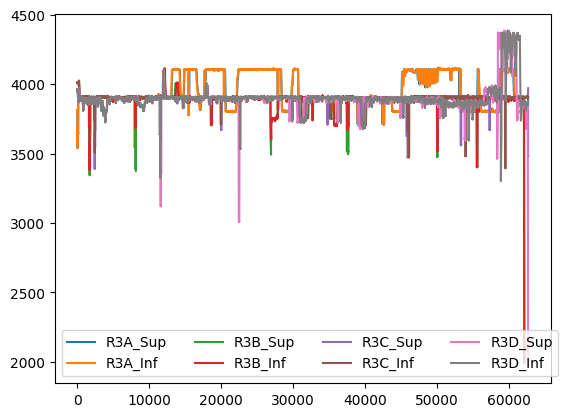

In [5]:
# Set a copy of the DF0 to work with
import copy
DFs = copy.deepcopy(DataFrames)
print(DataFrames['R3A_Sup'].columns)
print(DFs['R3A_Sup'].columns)

for key, df in DFs.items():
    df['Qair'] = lf.rolling_mean_centered(df['Qair'].values, 100)
    df = df.iloc[2370:65041]
    df.reset_index(drop = True, inplace = True)
    plt.plot(df['Qair'], label = key)
plt.legend(ncol = 4)

print(DataFrames['R3A_Sup'].columns)
print(DFs['R3A_Sup'].columns)


In [6]:
# Resamplt the df to get one value each hour
for key, df in DFs.items():
    df.drop(['Days'], axis = 1, inplace = True)
    df.set_index('Date', inplace = True)
    df = df.resample('60min').median()
    target_hours = 24
    df['TargetTMP'] = df['TMP'].shift(-target_hours)
    df.dropna(inplace = True)
    DFs[key] = df
print(DataFrames['R3A_Sup'].columns)
print(DFs['R3A_Sup'].columns)

Index(['Date', 'Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3',
       'Flux', 'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Days', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance'],
      dtype='object')
Index(['Qair', 'Qperm', 'TMP', 'O2', 'Temp', 'TSS', 'NH4', 'NO3', 'Flux',
       'Permeab', 'Hz', 'Minute', 'TMPmbar', 'FR', 'Chemicals',
       'After_Chemical_h', 'Visco', 'Resistance', 'TargetTMP'],
      dtype='object')


In [7]:
# Load model
with open('xgb_model_v1.pkl','rb') as f:
    model_xgb = pickle.load(f)

In [8]:
DFx = dict()
DFy = dict()
DFpred = dict()
for key, df in DFs.items():
    DFx[key] = df[['Qair', 'Temp', 'TSS', 'Flux', 'FR', 'Chemicals','After_Chemical_h', 'Resistance']].copy()
    DFy[key] = df['TargetTMP'].copy()
    DFpred[key] = model_xgb.predict(DFx[key])
    r2 = r2_score(DFy[key],DFpred[key])
    print(f'r2 {key} = {r2}')


r2 R3A_Sup = 0.8095034724364304
r2 R3A_Inf = 0.9316524559844037
r2 R3B_Sup = 0.4585405681141782
r2 R3B_Inf = 0.47406320381012756
r2 R3C_Sup = 0.4741051604169936
r2 R3C_Inf = 0.4399651938436401
r2 R3D_Sup = 0.5471177174394866
r2 R3D_Inf = 0.29463235337970783


In [9]:
for key in DFs.keys():
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=DFy[key], mode = 'lines', name = 'Real'))
    fig.add_trace(go.Scatter(y=DFpred[key], mode = 'lines', name = 'XGB'))
    fig.show()